In [2]:
import numpy as np
from scipy.io import loadmat
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

# ======================
# 1. 数据加载
# ======================
def load_cwru_data(file_paths, labels, segment_length=1024):
    X, y = [], []
    for file, label in zip(file_paths, labels):
        mat_dict = loadmat(file)
        key = [k for k in mat_dict.keys() if "DE" in k or "DE_time" in k][0]
        signal = mat_dict[key].squeeze()
        
        # 按 segment_length 切分
        num_segments = len(signal) // segment_length
        signal = signal[:num_segments * segment_length]
        segments = signal.reshape(num_segments, segment_length)
        
        X.append(segments)
        y.extend([label] * num_segments)
    
    X = np.vstack(X)
    y = np.array(y)
    return X, y

# 你的文件路径 & 标签（示例，按需替换）
# ===============================
# 数据路径配置（10分类）
# ===============================



# 加载数据
X, y = load_cwru_data(file_paths, labels)

print("数据形状:", X.shape, y.shape)

# 数据 reshape & one-hot
X = X[..., np.newaxis]   # (样本数, 1024, 1)
y = to_categorical(y, num_classes=10)

# 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("训练集:", X_train.shape, y_train.shape)
print("测试集:", X_test.shape, y_test.shape)

# ======================
# 2. ResNet1D 模型定义
# ======================
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # 第一层卷积
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 第二层卷积
    x = layers.Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # 匹配维度
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 残差连接
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet1d(input_shape=(1024,1), num_classes=10):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding="same")(x)

    # 堆叠残差块
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

# ======================
# 3. 训练
# ======================
model = build_resnet1d(input_shape=(1024,1), num_classes=10)
model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

# ======================
# 4. 测试
# ======================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_acc)


数据形状: (1305, 1024) (1305,)
训练集: (1044, 1024, 1) (1044, 10)
测试集: (261, 1024, 1) (261, 10)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1024, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_15 (Conv1D)            │ (None, 512, 64)           │             512 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 512, 64)           │             256 │ conv1d_15[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_13 (ReLU)               │ (None, 512, 64)           │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 256, 64)           │               0 │ re_lu_13[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_16 (Conv1D)            │ (None, 256, 64)           │          12,352 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 256, 64)           │             256 │ conv1d_16[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 256, 64)           │               0 │ batch_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_17 (Conv1D)            │ (None, 256, 64)           │          12,352 │ re_lu_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 256, 64)           │             256 │ conv1d_17[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 256, 64)           │               0 │ batch_normalization_17[0]… │
│                               │                           │                 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_15 (ReLU)               │ (None, 256, 64)           │               0 │ add_6[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_18 (Conv1D)            │ (None, 256, 64)           │          12,352 │ re_lu_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 256, 64)           │             256 │ conv1d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 996,106 (3.80 MB)

 Trainable params: 991,626 (3.78 MB)

 Non-trainable params: 4,480 (17.50 KB)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.4244 - loss: 1.6483 - val_accuracy: 0.3206 - val_loss: 2.1361
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.8647 - loss: 0.4218 - val_accuracy: 0.0718 - val_loss: 2.4776
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.8872 - loss: 0.3013 - val_accuracy: 0.3397 - val_loss: 2.2001
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9066 - loss: 0.2535 - val_accuracy: 0.3110 - val_loss: 2.7109
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9192 - loss: 0.2536 - val_accuracy: 0.0813 - val_loss: 4.6127
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9370 - loss: 0.2035 - val_accuracy: 0.1100 - val_loss: 4.2439
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.9537 - loss: 0.1499 - val_accuracy: 0.0574 - val_loss: 6.4093
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.9167 - loss: 0.2428 - val_accuracy: 0.

# 切割更细致，增加数据量

In [3]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ========== 1. 配置数据路径 ==========
file_paths = [
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/B014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/Normal Baseline Data/Normal_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/OR007@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/IR014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/OR021@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/OR014@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/IR007_0.mat"
]
labels = ["B014", "Normal", "OR007", "IR014", "OR021", "OR014", "IR007"]  # 每个文件对应的类别名

# ========== 2. 数据预处理 ==========
def load_cwru_data(file_paths, labels, segment_length=1024, step=256):
    X, y = [], []
    for path, label in zip(file_paths, labels):
        data = loadmat(path)
        key = [k for k in data.keys() if "DE_time" in k][0]  # 提取 DE_time
        signal = data[key].squeeze()
        for i in range(0, len(signal) - segment_length, step):
            segment = signal[i:i + segment_length]
            X.append(segment)
            y.append(label)
    return np.array(X), np.array(y)

# 切分数据
X, y = load_cwru_data(file_paths, labels, segment_length=1024, step=256)
print("原始数据形状:", X.shape, y.shape)

# 标签编码
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(np.unique(y))

# 调整输入形状 [样本数, 时间步, 通道数]
X = X[..., np.newaxis]

# 划分训练/测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========== 3. ResNet1D 模型 ==========
def resnet_block(x, filters, kernel_size=16, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 16, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

model = build_resnet1d((1024,1), num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ========== 4. 训练 ==========
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,   # 数据多了，batch_size可以调大
    validation_data=(X_test, y_test)
)

# ========== 5. 测试 ==========
test_loss, test_acc = model.evaluate(X_test, y_test)
print("测试集准确率: {:.2f}%".format(test_acc * 100))



原始数据形状: (3783, 1024) (3783,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1024, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_15 (Conv1D)            │ (None, 512, 64)           │           1,088 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 512, 64)           │             256 │ conv1d_15[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_13 (ReLU)               │ (None, 512, 64)           │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_16 (Conv1D)            │ (None, 512, 64)           │          65,600 │ re_lu_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 512, 64)           │             256 │ conv1d_16[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 512, 64)           │               0 │ batch_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_17 (Conv1D)            │ (None, 512, 64)           │          65,600 │ re_lu_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 512, 64)           │             256 │ conv1d_17[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 512, 64)           │               0 │ batch_normalization_17[0]… │
│                               │                           │                 │ re_lu_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_15 (ReLU)               │ (None, 512, 64)           │               0 │ add_6[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_18 (Conv1D)            │ (None, 256, 128)          │         131,200 │ re_lu_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 256, 128)          │             512 │ conv1d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_16 (ReLU)               │ (None, 256, 128)          │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_19 (Conv1D)            │ (None, 256, 128)          │         262,27

 Total params: 4,247,367 (16.20 MB)

 Trainable params: 4,243,655 (16.19 MB)

 Non-trainable params: 3,712 (14.50 KB)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7167 - loss: 0.7908 - val_accuracy: 0.1268 - val_loss: 23.0188
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9923 - loss: 0.0326 - val_accuracy: 0.0568 - val_loss: 6.9766
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 0.2510 - val_loss: 6.8085
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.2510 - val_loss: 6.6765
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 1.0000 - loss: 6.5349e-04 - val_accuracy: 0.2510 - val_loss: 6.5171
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 1.0000 - loss: 3.9632e-04 - val_accuracy: 0.2510 - val_loss: 6.6373
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 1.0000 - loss: 6.2880e-04 - val_accuracy: 0.2510 - val_loss: 6.7122
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 1.0000 - loss: 2.1170e-04 - val_accuracy: 0

# 减小模型规模

In [4]:
import numpy as np
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# ------------------ 数据加载与切分 ------------------
file_paths = [
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/B014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/Normal Baseline Data/Normal_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/OR007@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/IR014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/OR021@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/OR014@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/IR007_0.mat"
]

labels = ["B014", "Normal", "OR007", "IR014", "OR021", "OR014", "IR007"]

window_size = 256  # 每段256步长

X, y = [], []

for file_path, label in zip(file_paths, labels):
    mat_data = sio.loadmat(file_path)
    key = [k for k in mat_data.keys() if "DE_time" in k][0]
    signal = mat_data[key].squeeze()
    
    # z-score 标准化
    signal = (signal - np.mean(signal)) / np.std(signal)

    # 切分成256的片段
    for i in range(0, len(signal) - window_size, window_size):
        X.append(signal[i:i+window_size])
        y.append(label)

X = np.array(X)
y = np.array(y)

# 标签转为数字
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# 数据 reshape (样本数, 256, 1)
X = X.reshape(-1, window_size, 1)

# 划分训练/验证/测试
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# ------------------ 轻量级 ResNet1D ------------------
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=stride, padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters, kernel_size, strides=1, padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding="same",
                          kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 构建 ResNet1D 模型（简化版）
def build_resnet1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(16, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 三个 stage，每个 stage 一个 residual block
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, stride=2)
    x = resnet_block(x, 64, stride=2)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# ------------------ 模型训练 ------------------
num_classes = len(np.unique(y))
model = build_resnet1d((window_size, 1), num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# ------------------ 测试集评估 ------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4419 - loss: 1.4900 - val_accuracy: 0.3363 - val_loss: 1.8037 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7777 - loss: 0.6813 - val_accuracy: 0.3082 - val_loss: 3.4177 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8836 - loss: 0.3900 - val_accuracy: 0.3835 - val_loss: 3.4302 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9123 - loss: 0.2923 - val_accuracy: 0.5499 - val_loss: 1.6696 - learning_rate: 0.0010
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9458 - loss: 0.2054 - val_accuracy: 0.8669 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9596 - loss: 0.1498 - val_accuracy: 0.9650 - val_loss: 0.1409 - learning_rate: 0.0010
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9750 - loss: 0.1134 - val_acc

# 加混淆矩阵和可视化训练过程

⚙️ 重新从 .mat 文件生成数据
训练集大小: (2434, 256, 1) (2434,)
验证集大小: (609, 256, 1) (609,)
测试集大小: (761, 256, 1) (761,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 128, 16)           │             128 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 16)           │              64 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 128, 16)           │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 128, 16)           │             784 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 16)           │              64 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 128, 16)           │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 128, 16)           │             784 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 16)           │              64 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 128, 16)           │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_2 (ReLU)                │ (None, 128, 16)           │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 64, 32)            │           1,568 │ re_lu_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 32)            │             128 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_3 (ReLU)                │ (None, 64, 32)            │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 64, 32)            │           3,10

 Total params: 29,383 (114.78 KB)

 Trainable params: 28,711 (112.15 KB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5739 - loss: 1.2776 - val_accuracy: 0.5878 - val_loss: 1.4870 - learning_rate: 0.0010
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9591 - loss: 0.2820 - val_accuracy: 0.6305 - val_loss: 1.1480 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9815 - loss: 0.1091 - val_accuracy: 0.7176 - val_loss: 0.8783 - learning_rate: 0.0010
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9957 - loss: 0.0582 - val_accuracy: 0.7537 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9933 - loss: 0.0567 - val_accuracy: 0.7406 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9954 - loss: 0.0483 - val_accuracy: 0.7718 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9988 - loss: 0.0345 - val_acc

D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) 

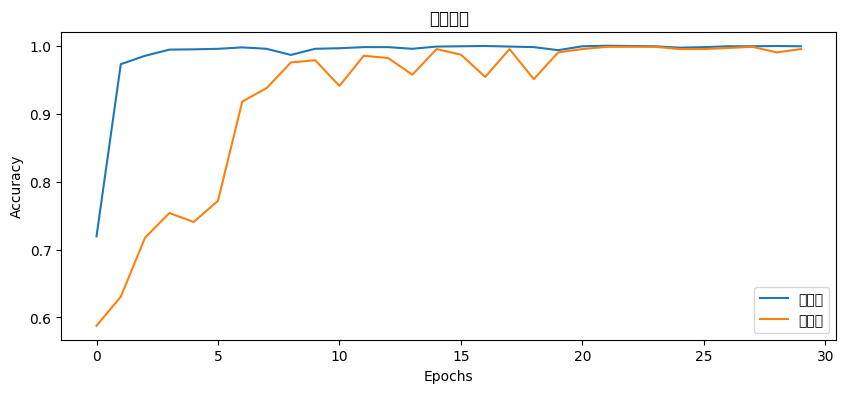

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\study\anaconda\envs\tf2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) 

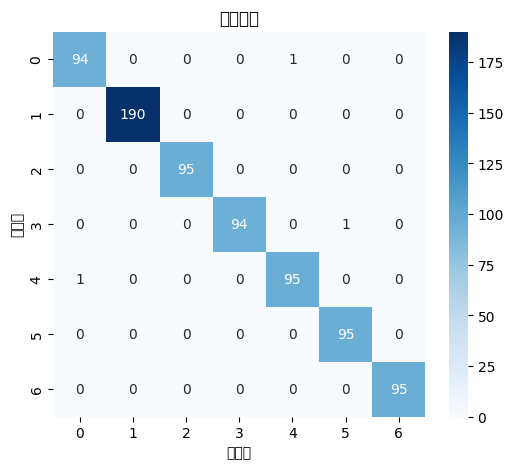

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        95
           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00        95
           3       1.00      0.99      0.99        95
           4       0.99      0.99      0.99        96
           5       0.99      1.00      0.99        95
           6       1.00      1.00      1.00        95

    accuracy                           1.00       761
   macro avg       1.00      1.00      1.00       761
weighted avg       1.00      1.00      1.00       761



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ===============================
# 1. 数据路径配置（你的文件路径）
# ===============================
file_paths = [
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/B014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/Normal Baseline Data/Normal_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/OR007@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/IR014_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/OR021@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/OR014@6_0.mat",
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/IR007_0.mat"
]
labels = [0, 1, 2, 3, 4, 5, 6]   # 每个文件对应的类别标签

segment_length = 256   # 每个样本长度
test_size = 0.2        # 训练/测试划分比例
val_size = 0.2         # 验证集划分比例（从训练集中再划）

# ===============================
# 2. 数据预处理函数
# ===============================
def load_and_segment_data(file_paths, labels, segment_length):
    X, y = [], []
    for file, label in zip(file_paths, labels):
        mat_dict = loadmat(file)
        key = [k for k in mat_dict.keys() if "DE_time" in k][0]   # 找到驱动端数据
        signal = mat_dict[key].squeeze()

        # 切分为256步长片段
        n_segments = len(signal) // segment_length
        signal = signal[:n_segments * segment_length]
        signal = signal.reshape(n_segments, segment_length)

        X.append(signal)
        y.extend([label] * n_segments)

    X = np.vstack(X)
    y = np.array(y)
    return X, y

# ===============================
# 3. 判断是否已有预处理数据
# ===============================
if all(os.path.exists(f) for f in ["X_train.npy","y_train.npy","X_val.npy","y_val.npy","X_test.npy","y_test.npy"]):
    print("✅ 发现已有预处理数据，直接加载")
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_val   = np.load("X_val.npy")
    y_val   = np.load("y_val.npy")
    X_test  = np.load("X_test.npy")
    y_test  = np.load("y_test.npy")
else:
    print("⚙️ 重新从 .mat 文件生成数据")
    X, y = load_and_segment_data(file_paths, labels, segment_length)

    # 先划分 训练+临时 / 测试
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    # 再划分 训练 / 验证
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, stratify=y_train_full, random_state=42)

    # 归一化 & 扩展维度 (CNN输入: [样本数, 256, 1])
    mean, std = np.mean(X_train), np.std(X_train)
    X_train = ((X_train - mean) / std)[..., np.newaxis]
    X_val   = ((X_val   - mean) / std)[..., np.newaxis]
    X_test  = ((X_test  - mean) / std)[..., np.newaxis]

    # 保存
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_val.npy", X_val)
    np.save("y_val.npy", y_val)
    np.save("X_test.npy", X_test)
    np.save("y_test.npy", y_test)

print("训练集大小:", X_train.shape, y_train.shape)
print("验证集大小:", X_val.shape, y_val.shape)
print("测试集大小:", X_test.shape, y_test.shape)

# ===============================
# 4. 定义 ResNet1D 模型（小规模）
# ===============================
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # shortcut 调整
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 残差层（缩小规模）
    x = residual_block(x, 16)
    x = residual_block(x, 32, stride=2)
    x = residual_block(x, 64, stride=2)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

num_classes = len(np.unique(y_train))
model = build_resnet1d(input_shape=(segment_length,1), num_classes=num_classes)
model.summary()

# ===============================
# 5. 训练模型
# ===============================
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ===============================
# 6. 结果评估
# ===============================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"测试集准确率: {test_acc:.4f}")

# 学习曲线
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="训练集")
plt.plot(history.history["val_accuracy"], label="验证集")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("学习曲线")
plt.show()

# 混淆矩阵
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("预测值"); plt.ylabel("真实值"); plt.title("混淆矩阵")
plt.show()

print(classification_report(y_test, y_pred))



# 尝试10分类

⚙️ 重新从 .mat 文件生成数据
训练集大小: (3350, 256, 1) (3350,)
验证集大小: (838, 256, 1) (838,)
测试集大小: (1047, 256, 1) (1047,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 256, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_84 (Conv1D)            │ (None, 128, 16)           │             128 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_84        │ (None, 128, 16)           │              64 │ conv1d_84[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_68 (ReLU)               │ (None, 128, 16)           │               0 │ batch_normalization_84[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_85 (Conv1D)            │ (None, 128, 16)           │             784 │ re_lu_68[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_85        │ (None, 128, 16)           │              64 │ conv1d_85[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_69 (ReLU)               │ (None, 128, 16)           │               0 │ batch_normalization_85[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_86 (Conv1D)            │ (None, 128, 16)           │             784 │ re_lu_69[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_86        │ (None, 128, 16)           │              64 │ conv1d_86[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_30 (Add)                  │ (None, 128, 16)           │               0 │ batch_normalization_86[0]… │
│                               │                           │                 │ re_lu_68[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_70 (ReLU)               │ (None, 128, 16)           │               0 │ add_30[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_87 (Conv1D)            │ (None, 64, 32)            │           1,568 │ re_lu_70[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_87        │ (None, 64, 32)            │             128 │ conv1d_87[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_71 (ReLU)               │ (None, 64, 32)            │               0 │ batch_normalization_87[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_88 (Conv1D)            │ (None, 64, 32)            │           3,10

 Total params: 29,578 (115.54 KB)

 Trainable params: 28,906 (112.91 KB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3884 - loss: 1.8153 - val_accuracy: 0.3759 - val_loss: 1.8930 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8708 - loss: 0.5620 - val_accuracy: 0.1635 - val_loss: 2.3400 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9457 - loss: 0.2773 - val_accuracy: 0.1587 - val_loss: 2.4403 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9658 - loss: 0.1603 - val_accuracy: 0.3914 - val_loss: 1.9406 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.1039 - val_accuracy: 0.5430 - val_loss: 1.2650 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9845 - loss: 0.0812 - val_accuracy: 0.8413 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9924 - loss: 0.0597 - val_acc

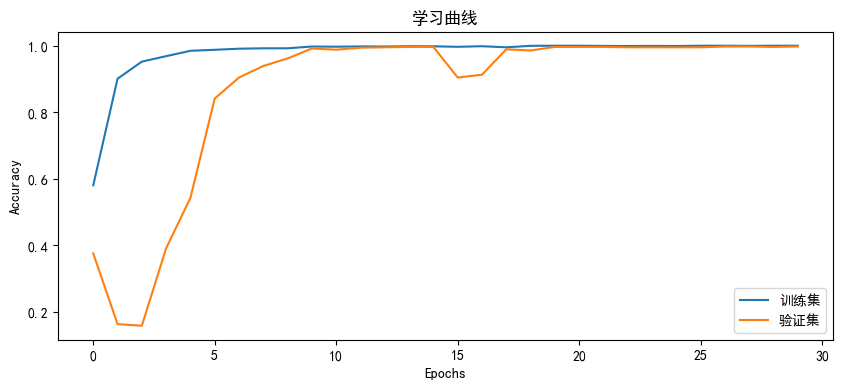

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


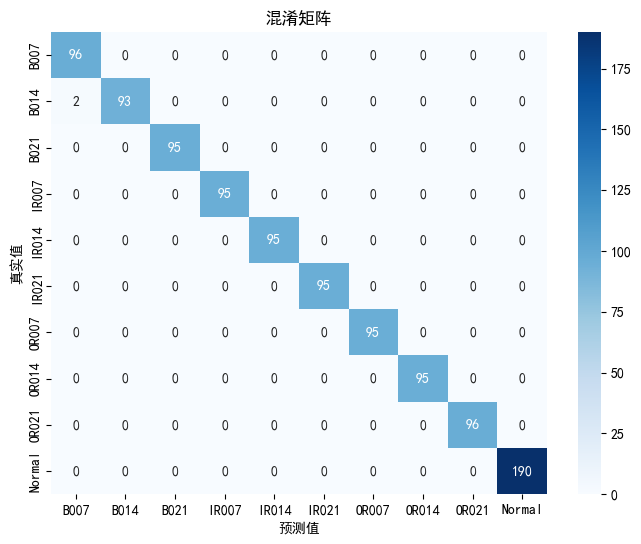

              precision    recall  f1-score   support

        B007       0.98      1.00      0.99        96
        B014       1.00      0.98      0.99        95
        B021       1.00      1.00      1.00        95
       IR007       1.00      1.00      1.00        95
       IR014       1.00      1.00      1.00        95
       IR021       1.00      1.00      1.00        95
       OR007       1.00      1.00      1.00        95
       OR014       1.00      1.00      1.00        95
       OR021       1.00      1.00      1.00        96
      Normal       1.00      1.00      1.00       190

    accuracy                           1.00      1047
   macro avg       1.00      1.00      1.00      1047
weighted avg       1.00      1.00      1.00      1047



In [9]:
# ===============================
# 1. 导入依赖
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或 'Microsoft YaHei'
matplotlib.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

# ===============================
# 2. 导入数据、打标签、划分
# ===============================
file_paths = [
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/B007_0.mat",   # B007
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/B014_0.mat",   # B014
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/B021_0.mat",   # B021
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/IR007_0.mat",  # IR007
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/IR014_0.mat",  # IR014
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/IR021_0.mat",  # IR021
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.007/OR007@6_0.mat",# OR007
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.014/OR014@6_0.mat",# OR014
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/12k Drive End Bearing Fault Data/0.021/OR021@6_0.mat",# OR021
    r"D:/HuaweiMoveData/Users/hps_h/Desktop/CWRU/Normal Baseline Data/Normal_0.mat"                     # Normal
]

labels = list(range(10))  # 10个类别

segment_length = 256   # 每个样本长度
overlap = 0.0          # 重叠率（0.0=无重叠，0.5=50%重叠）
test_size = 0.2        # 训练/测试划分比例
val_size = 0.2         # 验证集划分比例（从训练集中再划）

# ===============================
# 3. 数据预处理函数
# ===============================
def load_and_segment_data(file_paths, labels, segment_length):
    X, y = [], []
    for file, label in zip(file_paths, labels):
        mat_dict = loadmat(file)
        key = [k for k in mat_dict.keys() if "DE_time" in k][0]   # 找到驱动端数据
        signal = mat_dict[key].squeeze()

        # 切分为256步长片段
        n_segments = len(signal) // segment_length
        signal = signal[:n_segments * segment_length]
        signal = signal.reshape(n_segments, segment_length)

        X.append(signal)
        y.extend([label] * n_segments)

    X = np.vstack(X)
    y = np.array(y)
    return X, y

# ===============================
# 4. 判断是否已有预处理数据
# ===============================
if all(os.path.exists(f) for f in ["X_train.npy","y_train.npy","X_val.npy","y_val.npy","X_test.npy","y_test.npy"]):
    print("✅ 发现已有预处理数据，直接加载")
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_val   = np.load("X_val.npy")
    y_val   = np.load("y_val.npy")
    X_test  = np.load("X_test.npy")
    y_test  = np.load("y_test.npy")
else:
    print("⚙️ 重新从 .mat 文件生成数据")
    X, y = load_and_segment_data(file_paths, labels, segment_length)

    # 先划分 训练+临时 / 测试
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    # 再划分 训练 / 验证
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, stratify=y_train_full, random_state=42)

    # 归一化 & 扩展维度 (CNN输入: [样本数, 256, 1])
    mean, std = np.mean(X_train), np.std(X_train)
    X_train = ((X_train - mean) / std)[..., np.newaxis]
    X_val   = ((X_val   - mean) / std)[..., np.newaxis]
    X_test  = ((X_test  - mean) / std)[..., np.newaxis]

    # 保存
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_val.npy", X_val)
    np.save("y_val.npy", y_val)
    np.save("X_test.npy", X_test)
    np.save("y_test.npy", y_test)

print("训练集大小:", X_train.shape, y_train.shape)
print("验证集大小:", X_val.shape, y_val.shape)
print("测试集大小:", X_test.shape, y_test.shape)

# ===============================
# 5. 定义 ResNet1D 模型（小规模）
# ===============================
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # shortcut 调整
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 残差层（缩小规模）
    x = residual_block(x, 16)
    x = residual_block(x, 32, stride=2)
    x = residual_block(x, 64, stride=2)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

num_classes = len(np.unique(y_train))
model = build_resnet1d(input_shape=(segment_length,1), num_classes=num_classes)
model.summary()

# ===============================
# 6. 训练模型
# ===============================
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ===============================
# 7. 结果评估
# ===============================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"测试集准确率: {test_acc:.4f}")

# 绘制学习曲线
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="训练集")
plt.plot(history.history["val_accuracy"], label="验证集")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("学习曲线")
plt.show()

# 绘制混淆矩阵及分类报告
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
class_names = ["B007","B014","B021","IR007","IR014","IR021","OR007","OR014","OR021","Normal"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("预测值"); plt.ylabel("真实值"); plt.title("混淆矩阵")
plt.show()


print(classification_report(y_test, y_pred, target_names=class_names))

# 尽量别动了，这个文件运行任何一个cell都会在D盘直接生成npy文件